[datacamp link](https://www.datacamp.com/courses/fraud-detection-in-python)

Useful online tutorial:

[Credit Card Fraud Detection
](https://www.kaggle.com/mlg-ulb/creditcardfraud/kernels)


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

In [0]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics.cluster.supervised import homogeneity_score
from sklearn.metrics.cluster.unsupervised import silhouette_score

In [0]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
from gensim import corpora

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


**Course Description**

A typical organization loses an estimated 5% of its yearly revenue to fraud. In this course, you will learn how to fight fraud by using data. For example, you'll learn how to apply supervised learning algorithms to detect fraudulent behavior similar to past ones, as well as unsupervised learning methods to discover new types of fraud activities. Moreover, in fraud analytics you often deal with **highly imbalanced datasets** when classifying fraud versus non-fraud, and during this course you will pick up some techniques on how to deal with that. The course provides a mix of technical and theoretical insights and shows you hands-on how to practically implement fraud detection models. In addition, you will get tips and advice from real-life experience to help you prevent making common mistakes in fraud analytics.

## 1. Introduction and preparing your data

In this chapter, you''ll learn about the typical challenges associated with fraud detection, and will learn how to resample your data in a smart way, to tackle problems with imbalanced data.

### Introduction to fraud detection



#### Checking the fraud to non-fraud ratio
In this chapter, you will work on `creditcard_data.csv`, a dataset containing credit card transactions data. Fraud occurrences are fortunately an extreme minority in these transactions.

However, Machine Learning algorithms usually work best when the different classes contained in the dataset are more or less equally present. If there are few cases of fraud, then there's little data to learn how to identify them. This is known as **class imbalance**, and it's one of the **main challenges of fraud detection**.

In [0]:
# Import pandas and read csv
import pandas as pd
# df = pd.read_csv("creditcard_data.csv")
df = pd.read_csv("creditcard_sampledata_3.csv")
# Explore the features available in your dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 31 columns):
Unnamed: 0    5050 non-null int64
V1            5050 non-null float64
V2            5050 non-null float64
V3            5050 non-null float64
V4            5050 non-null float64
V5            5050 non-null float64
V6            5050 non-null float64
V7            5050 non-null float64
V8            5050 non-null float64
V9            5050 non-null float64
V10           5050 non-null float64
V11           5050 non-null float64
V12           5050 non-null float64
V13           5050 non-null float64
V14           5050 non-null float64
V15           5050 non-null float64
V16           5050 non-null float64
V17           5050 non-null float64
V18           5050 non-null float64
V19           5050 non-null float64
V20           5050 non-null float64
V21           5050 non-null float64
V22           5050 non-null float64
V23           5050 non-null float64
V24           5050 non-null flo

In [0]:
df.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,258647,1.725265,-1.337256,-1.012687,-0.361656,-1.431611,-1.098681,-0.842274,-0.026594,-0.032409,0.215113,1.618952,-0.654046,-1.442665,-1.546538,-0.230008,1.785539,1.419793,0.071666,0.233031,0.275911,0.414524,0.793434,0.028887,0.419421,-0.367529,-0.155634,-0.015768,0.010790,189.00,0
1,69263,0.683254,-1.681875,0.533349,-0.326064,-1.455603,0.101832,-0.520590,0.114036,-0.601760,0.444011,1.521570,0.499202,-0.127849,-0.237253,-0.752351,0.667190,0.724785,-1.736615,0.702088,0.638186,0.116898,-0.304605,-0.125547,0.244848,0.069163,-0.460712,-0.017068,0.063542,315.17,0
2,96552,1.067973,-0.656667,1.029738,0.253899,-1.172715,0.073232,-0.745771,0.249803,1.383057,-0.483771,-0.782780,0.005242,-1.273288,-0.269260,0.091287,-0.347973,0.495328,-0.925949,0.099138,-0.083859,-0.189315,-0.426743,0.079539,0.129692,0.002778,0.970498,-0.035056,0.017313,59.98,0
3,281898,0.119513,0.729275,-1.678879,-1.551408,3.128914,3.210632,0.356276,0.920374,-0.160589,-0.801748,0.137341,-0.156740,-0.429388,-0.752392,0.155272,0.215068,0.352222,-0.376168,-0.398920,0.043715,-0.335825,-0.906171,0.108350,0.593062,-0.424303,0.164201,0.245881,0.071029,0.89,0
4,86917,1.271253,0.275694,0.159568,1.003096,-0.128535,-0.608730,0.088777,-0.145336,0.156047,0.022707,-0.963306,-0.228074,-0.324933,0.390609,1.065923,0.285930,-0.627072,0.170175,-0.215912,-0.147394,0.031958,0.123503,-0.174528,-0.147535,0.735909,-0.262270,0.015577,0.015955,6.53,0


In [0]:
# Count the occurrences of fraud and no fraud and print them
occ = df['Class'].value_counts()
print(occ)

# Print the ratio of fraud cases
print(occ / len(df.index))

0    5000
1      50
Name: Class, dtype: int64
0    0.990099
1    0.009901
Name: Class, dtype: float64


####Plotting your data

From the previous exercise we know that the ratio of fraud to non-fraud observations is very low. You can do something about that, for example by re-sampling our data, which is explained in the next video.

In [0]:
# match 
df = df.drop(['Unnamed: 0'], axis=1) #
df.shape

(5050, 30)

In [0]:
# pre-loaded
def prep_data(df):
    X = df.iloc[:, 1:29]
    X = np.array(X).astype(np.float)
    y = df.iloc[:, 29]
    y=np.array(y).astype(np.float)
    return X,y

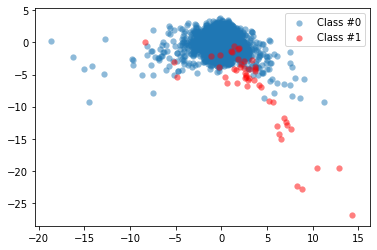

In [0]:
# Define a function to create a scatter plot of our data and labels
def plot_data(X, y):
	plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
	plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
	plt.legend()
	return plt.show()

# Create X and y from our above defined function
X, y = prep_data(df)

# Plot our data by running our plot data function on X and y
plot_data(X, y)

### Increasing successful detections using data resampling


#### Applying SMOTE

In this exercise, you're going to re-balance our data using the **Synthetic Minority Over-sampling Technique** (SMOTE). 

Unlike ROS, SMOTE does not create exact copies of observations, but creates new, synthetic, samples that are quite similar to the existing observations in the minority class. SMOTE is therefore slightly more sophisticated than just copying observations, so let's apply SMOTE to our credit card data. 

In [0]:
from imblearn.over_sampling import SMOTE

# Run the prep_data function
X, y = prep_data(df)

# Define the resampling method
method = SMOTE(kind='regular')

In [0]:
# Create the resampled feature set
X_resampled, y_resampled = method.fit_sample(X, y)

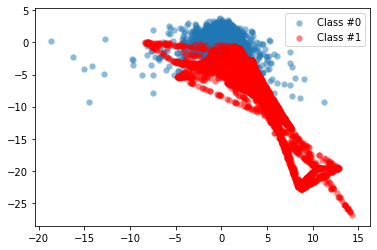

In [0]:
# Plot the resampled data
plot_data(X_resampled, y_resampled)

####Compare SMOTE to original data

In [0]:
# pre-loaded
def compare_plot(X,y,X_resampled,y_resampled, method):
    # Start a plot figure
    f, (ax1, ax2) = plt.subplots(1, 2)
    # sub-plot number 1, this is our normal data
    c0 = ax1.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0",alpha=0.5)
    c1 = ax1.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1",alpha=0.5, c='r')
    ax1.set_title('Original set')
    # sub-plot number 2, this is our oversampled data
    ax2.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1], label="Class #0", alpha=.5)
    ax2.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1], label="Class #1", alpha=.5,c='r')
    ax2.set_title(method)
    # some settings and ready to go
    plt.figlegend((c0, c1), ('Class #0', 'Class #1'), loc='lower center',
                  ncol=2, labelspacing=0.)
    #plt.tight_layout(pad=3)
    return plt.show()

0.0    5000
1.0      50
dtype: int64
1.0    5000
0.0    5000
dtype: int64


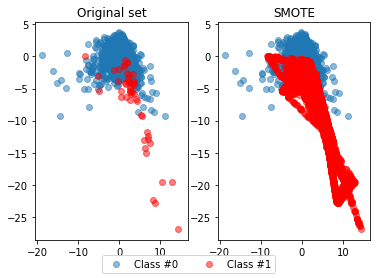

In [0]:
# Print the value_counts on the original labels y
print(pd.value_counts(pd.Series(y)))

# Print the value_counts
print(pd.value_counts(pd.Series(y_resampled)))

# Run compare_plot
compare_plot(X, y, X_resampled, y_resampled, method='SMOTE')

###Fraud detection algorithms in action


####Exploring the traditional way to catch fraud

- First you'll define threshold values using common statistics, to split fraud and non-fraud. 

- Then, use those thresholds on your features to detect fraud. This is common practice within fraud analytics teams.

In [0]:
# Run a groupby command on our labels and obtain the mean for each feature
df.groupby('Class').mean()

# Implement a rule for stating which cases are flagged as fraud
df['flag_as_fraud'] = np.where(np.logical_and(df['V1'] < -3, df['V3'] < -5), 1, 0)

# Create a crosstab of flagged fraud cases versus the actual fraud cases
print(pd.crosstab(df.Class, df.flag_as_fraud, rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

Flagged Fraud     0   1
Actual Fraud           
0              4984  16
1                28  22


####Using ML classification to catch fraud


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [0]:
# Create the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fit a logistic regression model to our data
model = LogisticRegression()
model.fit(X_train, y_train)

# Obtain model predictions
predicted = model.predict(X_test)

# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1505
         1.0       0.89      0.80      0.84        10

    accuracy                           1.00      1515
   macro avg       0.94      0.90      0.92      1515
weighted avg       1.00      1.00      1.00      1515

Confusion matrix:
 [[1504    1]
 [   2    8]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


####Logistic regression combined with SMOTE

In [0]:
# This is the pipeline module we need for this from imblearn
from imblearn.pipeline import Pipeline 

# Define which resampling method and which ML model to use in the pipeline
resampling = SMOTE(kind='borderline2')
model = LogisticRegression()

# Define the pipeline, tell it to combine SMOTE with the Logistic Regression model
pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', model)])

####Using a pipeline


In [0]:
# Split your data X and y, into a training and a test set and fit the pipeline onto the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data 
pipeline.fit(X_train, y_train) 
predicted = pipeline.predict(X_test)

# Obtain the results from the classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classifcation report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1505
         1.0       0.62      1.00      0.77        10

    accuracy                           1.00      1515
   macro avg       0.81      1.00      0.88      1515
weighted avg       1.00      1.00      1.00      1515

Confusion matrix:
 [[1499    6]
 [   0   10]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## 2. Fraud detection using labelled data
 
Now that you're familiar with the main challenges of fraud detection, you're about to learn how to flag fraudulent transactions with supervised learning. You will use classifiers, adjust them and compare them to find the most efficient fraud detection model.

### Review of classification methods


####Natural hit rate

First you need to explore how prevalent fraud is in the dataset, to understand what the "**natural accuracy**" is, if we were to predict everything as non-fraud. 

It's is important to understand which level of "accuracy" you need to "beat" in order to get a better prediction than by doing nothing. 

In the following exercises, you'll create our first random forest classifier for fraud detection. That will serve as the "baseline" model that you're going to try to improve in the upcoming exercises.

In [0]:
# Count the total number of observations from the length of y
total_obs = len(y)

# Count the total number of non-fraudulent observations 
non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)

# Calculate the percentage of non fraud observations in the dataset
percentage = (float(count_non_fraud)/float(total_obs)) * 100

# Print the percentage: this is our "natural accuracy" by doing nothing
print(percentage)

99.00990099009901


####Random Forest Classifier

In [0]:
# Import the random forest model from sklearn
from sklearn.ensemble import RandomForestClassifier

# Split your data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Define the model as the random forest
model = RandomForestClassifier(random_state=5)

- Let's see how our Random Forest model performs without doing anything special to it. 

In [0]:
# Fit the model to our training set
model.fit(X_train, y_train)

# Obtain predictions from the test data 
predicted = model.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
from sklearn.metrics import accuracy_score

In [0]:
# Print the accuracy performance metric
print(accuracy_score(y_test, predicted))

0.9986798679867986


**Random Forests vs. Decision Trees:**

**Random Forest prevents overfitting** most of the time, by creating random subsets of the features and building smaller trees using these subsets. Afterwards, it combines the subtrees of subsamples of features, so it does not tend to overfit to your entire feature set the way "deep" Decisions Trees do.

###Performance evaluation


####Performance metrics for the RF model

With highly **imbalanced** fraud data, the **AUROC** curve is a more reliable performance metric, used to compare different classifiers. 

Moreover, the **classification** report tells you about the precision and recall of your model, whilst the **confusion matrix** actually shows how many fraud cases you can predict correctly. So let's get these performance metrics.

In [0]:
# Import the packages to get the different performance metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Obtain the predictions from our random forest model 
predicted = model.predict(X_test)

# Predict probabilities
probs = model.predict_proba(X_test)

# Print the ROC curve, classification report and confusion matrix
print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

0.9993687707641197
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1505
         1.0       0.90      0.90      0.90        10

    accuracy                           1.00      1515
   macro avg       0.95      0.95      0.95      1515
weighted avg       1.00      1.00      1.00      1515

[[1504    1]
 [   1    9]]


####Plotting the Precision Recall Curve


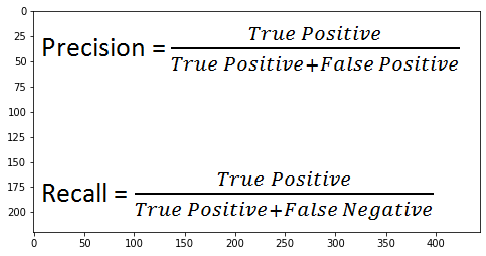

In [2]:
import matplotlib.pyplot as plt
img = plt.imread('1_7J08ekAwupLBegeUI8muHA.png')
fig= plt.figure(figsize=(8,5))
plt.imshow(img)

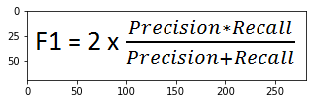

In [5]:
import matplotlib.pyplot as plt
img = plt.imread('1_T6kVUKxG_Z4V5Fm1UXhEIw.png')
fig= plt.figure(figsize=(5,3))
plt.imshow(img)

In [0]:
from sklearn.metrics import average_precision_score

In [0]:
# Calculate average precision and the PR curve
average_precision = average_precision_score(y_test, predicted)

In [0]:
from sklearn.metrics import precision_recall_curve

In [0]:
# pre-loaded
def plot_pr_curve(recall, precision, average_precision):
  plt.step(recall, precision, color='b', alpha=0.2, where='post')
  plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
  plt.show()

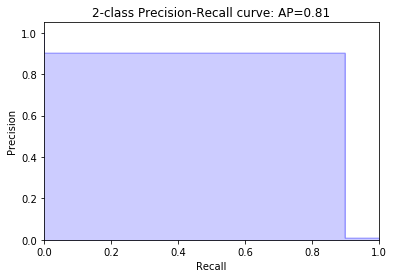

In [0]:
# Obtain precision and recall
precision, recall, _ = precision_recall_curve(y_test, predicted)

# Plot the recall precision tradeoff
plot_pr_curve(recall, precision, average_precision)

#### What's the benefit of the performance metric ROC curve (AUROC) versus Precision and Recall?

Correct answer:

The **AUROC** answers the question: "**How well can this classifier be expected to perform in general, at a variety of different baseline probabilities?**" but precision and recall don't.


The ROC curve plots the true positives vs. false positives , for a classifier, as its discrimination threshold is varied. Since, a random method describes a horizontal curve through the unit interval, it has an AUC of 0.5. Minimally, classifiers should perform better than this, and the extent to which they score higher than one another (meaning the area under the ROC curve is larger), they have better expected performance.

###Adjusting your algorithm weights


In [0]:
# Define the model with balanced subsample
model = RandomForestClassifier(class_weight='balanced_subsample', random_state=5)

# Fit your training model to your training set
model.fit(X_train, y_train)

# Obtain the predicted values and probabilities from the model 
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

# Print the roc_auc_score, the classification report and confusion matrix
print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

0.999468438538206
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1505
         1.0       0.90      0.90      0.90        10

    accuracy                           1.00      1515
   macro avg       0.95      0.95      0.95      1515
weighted avg       1.00      1.00      1.00      1515

[[1504    1]
 [   1    9]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


- In the next exercises you'll see how to more smartly tweak your model to focus on reducing false negatives and catch more fraud.

####Adjusting your Random Forest to fraud detection

You'll define weights manually, to be able to off-set that imbalance slightly. 

In [0]:
# pre-defined

def get_model_results(X_train, y_train, X_test, y_test, model):
  model.fit(X_train, y_train)
  predicted = model.predict(X_test)
  probs = model.predict_proba(X_test)
  print (classification_report(y_test, predicted))
  print (confusion_matrix(y_test, predicted))

- Change the **weight option** to set the ratio to 1 to 12 for the non-fraud and fraud cases, and set the split criterion to 'entropy'.
- Set the maximum depth to 10.
- Set the minimal samples in leaf nodes to 10.
- Set the number of trees to use in the model to 20.

In [0]:
# Change the model options
model = RandomForestClassifier(bootstrap=True, class_weight={0:1, 1:12}, criterion='entropy',
                               
			# Change depth of model
            max_depth=10, 
                               
			# Change the number of samples in leaf nodes
            min_samples_leaf=10, 
                               
			# Change the number of trees to use
            n_estimators=20, n_jobs=-1, random_state=5)

# Run the function get_model_results
get_model_results(X_train, y_train, X_test, y_test, model)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1505
         1.0       0.83      1.00      0.91        10

    accuracy                           1.00      1515
   macro avg       0.92      1.00      0.95      1515
weighted avg       1.00      1.00      1.00      1515

[[1503    2]
 [   0   10]]


**Observation:**

You can see by smartly defining more options in the model, you can obtain better predictions. You have effectively reduced the number of false negatives, i.e. you are catching more cases of fraud, whilst keeping the number of false positives low.

There is a smarter way of doing it, by using `GridSearchCV`.

####GridSearchCV to find optimal parameters

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
# Define the parameter sets to test
param_grid = {'n_estimators': [1, 30], 'max_features': ['auto', 'log2'], 'max_depth': [4, 8], 'criterion': ['gini', 'entropy']
}

# Define the model to use
model = RandomForestClassifier(random_state=5)

# Combine the parameter sets with the defined model
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit the model to our training data and obtain best parameters
CV_model.fit(X_train, y_train)
CV_model.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'log2',
 'n_estimators': 30}

####Model results using GridSearchCV


In [0]:
def get_model_results(X_train, y_train, X_test, y_test, model):
  model.fit(X_train, y_train)
  predicted = model.predict(X_test)
  probs = model.predict_proba(X_test)
  print (classification_report(y_test, predicted))
  print (confusion_matrix(y_test, predicted))

In [0]:
# Input the optimal parameters in the model
model = RandomForestClassifier(class_weight={0:1,1:12}, criterion='gini',
            max_depth=8, max_features='log2', min_samples_leaf=10, n_estimators=30, n_jobs=-1, random_state=5)

# Get results from your model
get_model_results(X_train, y_train, X_test, y_test, model)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1505
         1.0       0.90      0.90      0.90        10

    accuracy                           1.00      1515
   macro avg       0.95      0.95      0.95      1515
weighted avg       1.00      1.00      1.00      1515

[[1504    1]
 [   1    9]]


### Ensemble methods


####Logistic Regression


In [0]:
# Define the Logistic Regression model with weights
model = LogisticRegression(class_weight={0:1, 1:15}, random_state=5)

# Get the model results
get_model_results(X_train, y_train, X_test, y_test, model)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1505
         1.0       0.57      0.80      0.67        10

    accuracy                           0.99      1515
   macro avg       0.79      0.90      0.83      1515
weighted avg       1.00      0.99      1.00      1515

[[1499    6]
 [   2    8]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


####Voting Classifier


In [0]:
from sklearn.tree import DecisionTreeClassifier

In [0]:
def get_model_results(X_train, y_train, X_test, y_test, model):
  model.fit(X_train, y_train)
  predicted = model.predict(X_test) # for classification
  #probs = model.predict_proba(X_test)
  print (classification_report(y_test, predicted))
  print (confusion_matrix(y_test, predicted))

In [0]:
# Import the package
from sklearn.ensemble import VotingClassifier

# Define the three classifiers to use in the ensemble
clf1 = LogisticRegression(class_weight={0:1, 1:15}, random_state=5)
clf2 = RandomForestClassifier(class_weight={0:1, 1:12}, criterion='gini', max_depth=8, max_features='log2',
                              min_samples_leaf=10, n_estimators=30, n_jobs=-1, random_state=5)
clf3 = DecisionTreeClassifier(random_state=5, class_weight="balanced")

# Combine the classifiers in the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3)], voting='hard')

# Get the results 
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1505
         1.0       0.89      0.80      0.84        10

    accuracy                           1.00      1515
   macro avg       0.94      0.90      0.92      1515
weighted avg       1.00      1.00      1.00      1515

[[1504    1]
 [   2    8]]


####Adjust weights within the Voting Classifier

In [0]:
# Define the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft', weights=[1, 4, 1], flatten_transform=True)

# Get results 
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1505
         1.0       0.91      1.00      0.95        10

    accuracy                           1.00      1515
   macro avg       0.95      1.00      0.98      1515
weighted avg       1.00      1.00      1.00      1515

[[1504    1]
 [   0   10]]


## 3. Fraud detection using unlabelled data

This chapter focuses on using unsupervised learning techniques to detect fraud. You will segment customers, use K-means clustering and other clustering algorithms to find suspicious occurrences in your data.

###Normal versus abnormal behavior


In [0]:
df = pd.read_csv("banksim.csv")
del df['Unnamed: 0']

In [0]:
# Get the dataframe shape
df.shape

(7200, 5)

In [0]:
# Display the first 5 rows
df.head()

,age,gender,category,amount,fraud
0,3,F,es_transportation,49.71,0
1,4,F,es_health,39.29,0
2,3,F,es_transportation,18.76,0
3,4,M,es_transportation,13.95,0
4,2,M,es_transportation,49.87,0


In [0]:
# Groupby categories and take the mean 
print(df.groupby('category').mean())

                           amount     fraud
category                                   
es_barsandrestaurants   43.841793  0.022472
es_contents             55.170000  0.000000
es_fashion              59.780769  0.020619
es_food                 35.216050  0.000000
es_health              126.604704  0.242798
es_home                120.688317  0.208333
es_hotelservices       172.756245  0.548387
es_hyper                46.788180  0.125000
es_leisure             229.757600  1.000000
es_otherservices       149.648960  0.600000
es_sportsandtoys       157.251737  0.657895
es_tech                132.852862  0.179487
es_transportation       27.422014  0.000000
es_travel              231.818656  0.944444
es_wellnessandbeauty    66.167078  0.060606


**Observation:**

The majority of fraud is observed in travel, leisure and sports related transactions.

####Customer segmentation


In [0]:
# Group by age groups and get the mean
print(df.groupby('age').mean())

        amount     fraud
age                     
0    49.468935  0.050000
1    35.622829  0.026648
2    37.228665  0.028718
3    37.279338  0.023283
4    36.197985  0.035966
5    37.547521  0.023990
6    36.700852  0.022293
U    39.117000  0.000000


In [0]:
# Count the values of the observations in each age group
print(df['age'].value_counts())

2    2333
3    1718
4    1279
5     792
1     713
6     314
0      40
U      11
Name: age, dtype: int64


**Observation:**

As you can see the average amount spent as well as fraud occurrence is rather **similar across groups**. Age group '0' stands out but since there are only 40 cases, it does not make sense to split these out in a separate group and run a separate model on them.

####Using statistics to define normal behavior

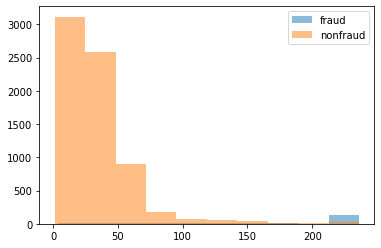

In [0]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = df.loc[df.fraud == 1] 
df_non_fraud = df.loc[df.fraud == 0]

# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud')
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud')
plt.legend()
plt.show()

### Clustering methods to detect fraud


In [0]:
# pre-loaded
df = pd.read_csv("banksim_adj.csv")

y = df.fraud.values.astype(np.float)

In [0]:
# match dataset
df = df.drop(['Unnamed: 0', 'fraud'], axis=1)
df.shape

(7189, 17)

####Scaling the data


In [0]:
# Import the scaler
from sklearn.preprocessing import MinMaxScaler

# Take the float values of df for X
X = df.values.astype(np.float)

# Define the scaler and apply to the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

####K-means clustering


In [0]:
# Import MiniBatchKmeans 
from sklearn.cluster import MiniBatchKMeans

# Define the model 
kmeans = MiniBatchKMeans(n_clusters=8, random_state=0)

# Fit the model to the scaled data
kmeans.fit(X_scaled)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=8, n_init=3, random_state=0, reassignment_ratio=0.01,
                tol=0.0, verbose=0)

####Elbow method

To decide which amount of clusters you're going to use, let's apply the Elbow method and see what the optimal number of clusters should be based on this method.

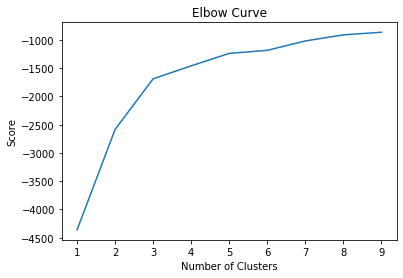

In [0]:
# Define the range of clusters to try
clustno = range(1, 10)

# Run MiniBatch Kmeans over the number of clusters
kmeans = [MiniBatchKMeans(n_clusters=i) for i in clustno]

# Obtain the score for each model
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

# Plot the models and their respective score 
plt.plot(clustno, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

### Assigning fraud versus non-fraud


####Detecting outliers

The fraudulent transactions are typically flagged as the observations that are furthest aways from the cluster centroid. 

You'll learn how to do this and how to determine the cut-off in this exercise. 

In [0]:
len(X_scaled) # 7189

7189

In [0]:
len(y) # 7189

7189

In [0]:
# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)

# Define K-means model 
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42).fit(X_train)

# Obtain predictions and calculate distance from cluster centroid
X_test_clusters = kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

# Create fraud predictions based on outliers on clusters 
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0

####Checking model results


In [0]:
# Obtain the ROC score
print(roc_auc_score(y_test, km_y_pred))

0.8109115999408585


In [0]:
# pre-defined
def plot_confusion_matrix(km_cm):
  df_cm = pd.DataFrame(km_cm, ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
  plt.figure(figsize = (8,4))
  sn.set(font_scale=1.4) 
  sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')
  plt.show()

In [0]:
import seaborn as sn

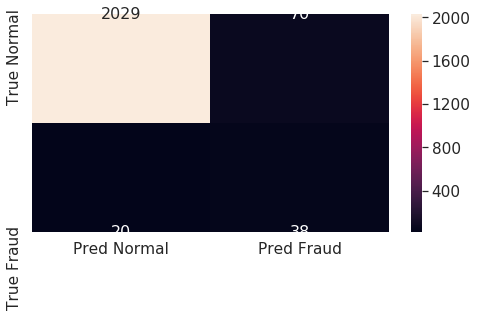

In [0]:
# Create a confusion matrix
km_cm = confusion_matrix(y_test, km_y_pred)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm)

**Observation:**

By lowering the threshold for cases flagged as fraud, you flag more cases overall but thereby also get more false positives.

### Other clustering fraud detection methods


#### DB Scan

The advantage of DBSCAN is that you do **not need to define the number of clusters** beforehand. Also, DBSCAN can handle **weirdly shaped** data (i.e. non-convex) much better than K-means can. 

This time, you are not going to take the outliers of the clusters and use that for fraud, but take the smallest clusters in the data and label those as fraud.

In [0]:
import pickle
file = open("labels_full.pickle", "rb")
labels = pickle.load(file)
file.close()

In [0]:
# datacamp used a subsample of this
labels

0       0
1       0
2       0
3       0
4       0
       ..
7184    1
7185    1
7186    1
7187    1
7188    1
Name: fraud, Length: 7189, dtype: int64

In [0]:
from sklearn.metrics.cluster.supervised import homogeneity_score
from sklearn.metrics.cluster.unsupervised import silhouette_score

In [0]:
len(pred_labels)

7189

In [0]:
# Import DBSCAN
from sklearn.cluster import DBSCAN

# Initialize and fit the DBscan model
db = DBSCAN(eps=0.9, min_samples=10, n_jobs=-1).fit(X_scaled)

# Obtain the predicted labels and calculate number of clusters
pred_labels = db.labels_
n_clusters = len(set(pred_labels)) - (1 if -1 in labels else 0)

# Print performance metrics for DBscan
print('Estimated number of clusters: %d' % n_clusters)
print("Homogeneity: %0.3f" % homogeneity_score(labels, pred_labels))
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_scaled, pred_labels))

Estimated number of clusters: 23
Homogeneity: 0.612
Silhouette Coefficient: 0.713


####Assessing smallest clusters

In this exercise you're going to have a look at the clusters that came out of DBscan, and flag certain clusters as fraud:

- you first need to figure out how big the clusters are, and filter out the smallest
- then, you're going to take the smallest ones and flag those as fraud
- last, you'll check with the original labels whether this does actually do a good job in detecting fraud.

In [0]:
# Count observations in each cluster number
counts = np.bincount(pred_labels[pred_labels >= 0])

# Print the result
print(counts)

[3252  145 2714   55  174  119  122   98   54   15   76   15   43   25
   51   47   42   15   25   20   19   10]


In [0]:
# Sort the sample counts of the clusters and take the top 3 smallest clusters
smallest_clusters = np.argsort(counts)[:3]

# Print the results 
print("The smallest clusters are clusters:")      
print(smallest_clusters)

The smallest clusters are clusters:
[21 17  9]


In [0]:
# Print the counts of the smallest clusters only
print("Their counts are:")      
print(counts[smallest_clusters])

Their counts are:
[10 15 15]


#### Checking results


In [0]:
# Create a dataframe of the predicted cluster numbers and fraud labels
df = pd.DataFrame({'clusternr':pred_labels,'fraud':labels})

# Create a condition flagging fraud for the smallest clusters 
df['predicted_fraud'] = np.where((df['clusternr']==21) | (df['clusternr']==17) | (df['clusternr']==9), 1, 0)

# Run a crosstab on the results 
print(pd.crosstab(df['fraud'], df['predicted_fraud'], rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

Flagged Fraud     0   1
Actual Fraud           
0              6973  16
1               176  24


## 4. Fraud detection using text


Fraud detection using text
100%


###Using text data


####Word search with dataframes


In this exercise you're going to work with text data, containing emails from Enron employees. The Enron scandal is a famous fraud case. Enron employees covered up the bad financial position of the company, thereby keeping the stock price artificially high. Enron employees sold their own stock options, and when the truth came out, Enron investors were left with nothing. The goal is to find all emails that mention specific words, such as "sell enron stock".



In [0]:
# pre-loaded
df = pd.read_csv("enron_emails_clean.csv")
df.shape

(2090, 6)

By using string operations on dataframes, you can easily sift through messy email data and create flags based on word-hits. The Enron email data has been put into a dataframe called df so let's search for suspicious terms. 

In [0]:
# Find all cleaned emails that contain 'sell enron stock'
mask = df['clean_content'].str.contains('sell enron stock', na=False)

In [0]:
# Select the data from df that contain the searched for words 
print(df.loc[mask])

                                       Message-ID  ...                                      clean_content
154  <6336501.1075841154311.JavaMail.evans@thyme>  ...  joint venture enron meeting belies officers cl...

[1 rows x 6 columns]


####Using list of terms


In [0]:
# Create a list of terms to search for
searchfor = ['enron stock', 'sell stock', 'stock bonus', 'sell enron stock']

# Filter cleaned emails on searchfor list and select from df 
filtered_emails = df.loc[df['clean_content'].str.contains('|'.join(searchfor), na=False)]
print(filtered_emails)

                                         Message-ID  ...                                      clean_content
0      <8345058.1075840404046.JavaMail.evans@thyme>  ...  investools advisory free digest trusted invest...
1      <1512159.1075863666797.JavaMail.evans@thyme>  ...  forwarded richard b sanders hou ect pm justin ...
2     <26118676.1075862176383.JavaMail.evans@thyme>  ...  hey wearing target purple shirt today mine wan...
3     <10369289.1075860831062.JavaMail.evans@thyme>  ...  leslie milosevich santa clara avenue alameda c...
4     <26728895.1075860815046.JavaMail.evans@thyme>  ...  rini twait e th ave longmont co rtwait graphic...
...                                             ...  ...                                                ...
1151  <15875618.1075860830584.JavaMail.evans@thyme>  ...  blanca anderson cadiz new orleans la bandersn ...
1450  <30798399.1075841348382.JavaMail.evans@thyme>  ...  enron announced today common stock traded coun...
1473    <957052.107586135913

####Creating a flag

This time you are going to create an actual flag variable that gives a `1` when the emails get a hit on the search terms of interest, and `0` otherwise. 


In [0]:
# Create flag variable where the emails match the searchfor terms
df['flag'] = np.where((df['clean_content'].str.contains('|'.join(searchfor)) == True), 1, 0)

# Count the values of the flag variable
count = df['flag'].value_counts()
print(count)

0    1776
1     314
Name: flag, dtype: int64


###Text mining to detect fraud


####Removing stopwords

In a first step you need to define the list of stopwords and punctuations that are to be removed in the next exercise from the text data. 


In [0]:
# subsample datasetdf 
df = df[:5]
# match dataset
df = df.drop('Message-ID', axis=1)
df.head()

,From,To,Date,content,clean_content
0,('advdfeedback@investools.com'),('advdfeedback@investools.com'),2002-01-29 23:20:55,INVESTools Advisory\nA Free Digest of Trusted ...,investools advisory free digest trusted invest...
1,('richard.sanders@enron.com'),('richard.sanders@enron.com'),2000-09-20 19:07:00,----- Forwarded by Richard B Sanders/HOU/ECT o...,forwarded richard b sanders hou ect pm justin ...
2,('m..love@enron.com'),('m..love@enron.com'),2001-10-30 16:15:17,hey you are not wearing your target purple shi...,hey wearing target purple shirt today mine wan...
3,('leslie.milosevich@kp.org'),('leslie.milosevich@kp.org'),2002-01-30 17:54:18,Leslie Milosevich\n1042 Santa Clara Avenue\nAl...,leslie milosevich santa clara avenue alameda c...
4,('rtwait@graphicaljazz.com'),('rtwait@graphicaljazz.com'),2002-01-30 19:36:01,"Rini Twait\n1010 E 5th Ave\nLongmont, CO 80501...",rini twait e th ave longmont co rtwait graphic...


In [0]:
df.shape

(5, 5)

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# Import nltk packages and string 
from nltk.corpus import stopwords 
import string

# Define stopwords to exclude
stop = set(stopwords.words('english'))
stop.update(("to","cc","subject","http","from","sent", "ect", "u", "fwd", "www", "com"))

# Define punctuations to exclude and lemmatizer
exclude = set(string.punctuation)

In [0]:
list(stop)[:5]

['my', 'each', 'ourselves', 'about', 'you']

In [0]:
list(exclude)[:5]

[')', '@', '=', '\\', ']']

####Cleaning text data

There are a few more steps to take before you have cleaned data, such as "lemmatization" of words, and stemming the verbs. 

The verbs in the email data are already stemmed, and the lemmatization is already done for you in this exercise.

In [0]:
# Import the lemmatizer from nltk
from nltk.stem.wordnet import WordNetLemmatizer
lemma = WordNetLemmatizer()

# Define word cleaning function
def clean(text, stop):
    text = text.rstrip()
	# Remove stopwords
    stop_free = " ".join([word for word in text.lower().split() if ((word not in stop) and (not word.isdigit()))])
	# Remove punctuations
    punc_free = ''.join(word for word in stop_free if word not in exclude)
	# Lemmatize all words
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())      
    return normalized

In [0]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
# Clean the emails in df and print results
text_clean=[]
for text in df['clean_content']:
    text_clean.append(clean(text, stop).split())    
print(text_clean)

[['investools', 'advisory', 'free', 'digest', 'trusted', 'investment', 'advice', 'unsubscribe', 'free', 'newsletter', 'please', 'see', 'issue', 'fried', 'sell', 'stock', 'gain', 'month', 'km', 'rowe', 'january', 'index', 'confirms', 'bull', 'market', 'aloy', 'small', 'cap', 'advisor', 'earns', 'lbix', 'compounding', 'return', 'pine', 'tree', 'pcl', 'undervalued', 'high', 'yield', 'bank', 'put', 'customer', 'first', 'aso', 'word', 'sponsor', 'top', 'wall', 'street', 'watcher', 'ben', 'zacks', 'year', 'year', 'gain', 'moving', 'best', 'brightest', 'wall', 'street', 'big', 'money', 'machine', 'earned', 'ben', 'zacks', 'five', 'year', 'average', 'annual', 'gain', 'start', 'outperforming', 'long', 'term', 'get', 'zacks', 'latest', 'stock', 'buylist', 'free', 'day', 'trial', 'investools', 'c', 'go', 'zaks', 'mtxtu', 'zakstb', 'investools', 'advisory', 'john', 'brobst', 'investools', 'fried', 'sell', 'stock', 'lock', 'month', 'km', 'david', 'fried', 'know', 'stock', 'undervalued', 'company', 

###Topic modeling on fraud


####Create dictionary and corpus

In order to run an LDA topic model, you first need to define your dictionary and corpus first, as those need to go into the model. 

In [0]:
# Import the packages
import gensim
from gensim import corpora

# Define the dictionary
dictionary = corpora.Dictionary(text_clean)

# Define the corpus
corpus = [dictionary.doc2bow(text) for text in text_clean]

# Print corpus and dictionary
print(dictionary)
print(corpus)

Dictionary(924 unique tokens: ['account', 'accurate', 'acquiring', 'acre', 'address']...)
[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 6), (6, 1), (7, 2), (8, 4), (9, 1), (10, 1), (11, 3), (12, 2), (13, 1), (14, 5), (15, 3), (16, 1), (17, 3), (18, 1), (19, 1), (20, 1), (21, 5), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 3), (31, 3), (32, 1), (33, 3), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 1), (48, 1), (49, 4), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 4), (56, 1), (57, 4), (58, 9), (59, 5), (60, 1), (61, 8), (62, 1), (63, 1), (64, 2), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 2), (78, 1), (79, 1), (80, 1), (81, 12), (82, 2), (83, 2), (84, 1), (85, 1), (86, 3), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 4), (96, 1), (97, 1), (98, 2), (99, 2), (100, 1), (101, 2

####LDA model

- Build the LDA model from gensim models, by inserting the corpus and dictionary.
- Save the 5 topics by running print topics on the model results, and select the top 5 words.

In [0]:
# Define the LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=5)

# Save the topics and top 5 words
topics = ldamodel.print_topics(num_words=5)

# Print the results
for topic in topics:
    print(topic)

(0, '0.003*"enron" + 0.002*"mg" + 0.002*"investools" + 0.002*"company" + 0.002*"stock"')
(1, '0.025*"enron" + 0.017*"employee" + 0.014*"company" + 0.014*"million" + 0.011*"stock"')
(2, '0.002*"enron" + 0.002*"rudolph" + 0.002*"mg" + 0.002*"jane" + 0.002*"investools"')
(3, '0.019*"investools" + 0.011*"stock" + 0.011*"go" + 0.010*"company" + 0.010*"say"')
(4, '0.021*"enron" + 0.021*"mg" + 0.015*"plc" + 0.014*"rudolph" + 0.014*"jane"')


###Flagging fraud based on topics


In [0]:
def get_topic_details(ldamodel, corpus):
    topic_details_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topic_details_df = topic_details_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
    topic_details_df.columns = ['Dominant_Topic', '% Score', 'Topic_Keywords']
    return topic_details_df

You'll be given the function `get_topic_details()` which takes the arguments ldamodel and corpus. It retrieves the details of the topics for each line of text. With that function, you can append the results back to your original data.

In [0]:
# Run get_topic_details function and check the results
print(get_topic_details(ldamodel, corpus))

   Dominant_Topic  % Score                                     Topic_Keywords
0             3.0   0.9992  investools, stock, go, company, say, year, see...
1             4.0   0.9990  enron, mg, plc, rudolph, jane, lon, allen, wol...
2             1.0   0.9944  enron, employee, company, million, stock, fund...
3             1.0   0.9935  enron, employee, company, million, stock, fund...
4             1.0   0.9934  enron, employee, company, million, stock, fund...


In [0]:
# Add original text to topic details in a dataframe
contents = pd.DataFrame({'Original text': text_clean})
topic_details = pd.concat([get_topic_details(ldamodel, corpus), contents], axis=1)
print(topic_details.head())

   Dominant_Topic  ...                                      Original text
0             3.0  ...  [investools, advisory, free, digest, trusted, ...
1             4.0  ...  [forwarded, richard, b, sander, hou, pm, justi...
2             1.0  ...  [hey, wearing, target, purple, shirt, today, m...
3             1.0  ...  [leslie, milosevich, santa, clara, avenue, ala...
4             1.0  ...  [rini, twait, e, th, ave, longmont, co, rtwait...

[5 rows x 4 columns]


In [0]:
# Create flag for text highest associated with topic 3
topic_details['flag'] = np.where((topic_details['Dominant_Topic'] == 3.0), 1, 0)
print(topic_details.head())

   Dominant_Topic  ...  flag
0             3.0  ...     1
1             4.0  ...     0
2             1.0  ...     0
3             1.0  ...     0
4             1.0  ...     0

[5 rows x 5 columns]
